# Vision transformers for binary class problem

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../code/")) #Add parent directory
from modules.utils import set_seed

SEED = 42
set_seed(SEED)

# Libraries

In [2]:
import torch
import numpy as np
from modules.data_loader_vit import get_data_loaders
from modules.model_vit import SkinLesionClassifier_VIT
from modules.train import train_model
from modules.utils import calculate_accuracy
from modules.visualize_aug import visualize_dataloader
from modules.plot_losses import plot_losses

# Connect to GPU

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Device: cuda


# Hyperparameters

In [4]:
batch_size = 64
num_epochs = 12
learning_rate = 0.0001
train_dir = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\train\train".replace("\\", "/")
val_dir = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\val\val".replace("\\", "/")

# Load data

In [5]:
train_loader, val_loader, test_loader = get_data_loaders(train_dir, val_dir, batch_size, seed = SEED)

Train set size: 15195
Validation set size: 1898
Test set size: 1898


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


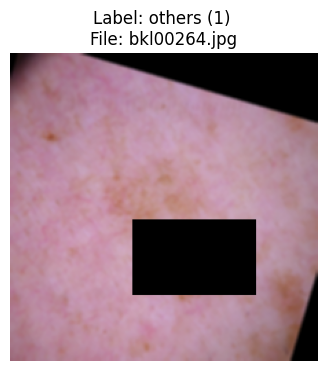

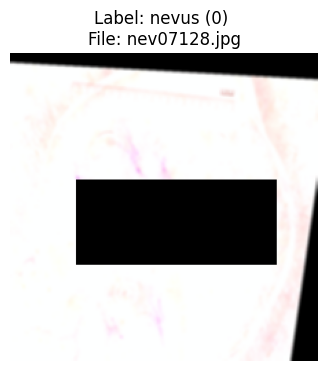

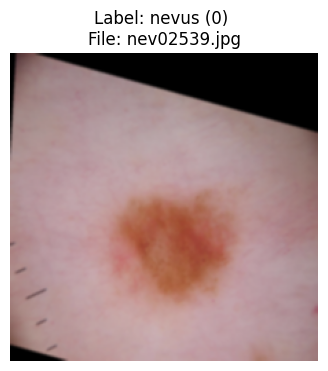

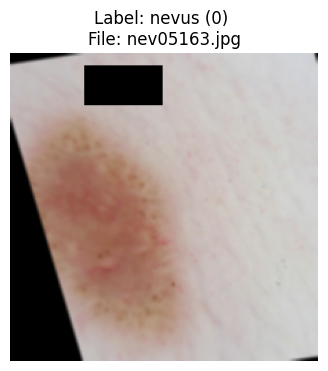

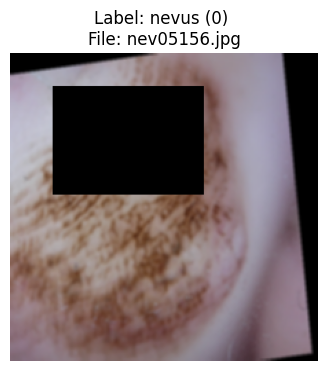

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(train_loader, mean, std, 5)

# Initialize model

In [7]:
#Initialize model
model = SkinLesionClassifier_VIT(num_classes=1).to(device)

## Loss and optimizers

In [8]:
criterion = torch.nn.BCEWithLogitsLoss() #tHE OTHER ONE EXPECTS THE INPUT TO BE PASSED THROUGH A LOGIT BEFORE. This one takes raw logits. Applies sigmoid activation internally to squash output between 0 and 1
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4) #Recommended for vision transformers as it improves generalization by decoupling weight decay from optimization step 
#New optimizer
optimizer = torch.optim.AdamW([
    {'params': model.model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.model.heads.parameters(), 'lr': 1e-4}
], weight_decay = 1e-4) #Weight decay can help in reducing overfitting
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)# works well in vision transformer and avoids abrupt changes

#Other schedulers
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1)

# Train the model

Best model saved with val acc: 0.8398 at epoch 1
Epoch 1 / 12 Training Loss: 0.4620 Training Accuracy: 0.7841 Validation Loss: 0.3683 Validation Accuracy: 0.8398
Best model saved with val acc: 0.8477 at epoch 2
Epoch 2 / 12 Training Loss: 0.3845 Training Accuracy: 0.8275 Validation Loss: 0.3415 Validation Accuracy: 0.8477
Best model saved with val acc: 0.8599 at epoch 3
Epoch 3 / 12 Training Loss: 0.3590 Training Accuracy: 0.8405 Validation Loss: 0.3282 Validation Accuracy: 0.8599
Best model saved with val acc: 0.8656 at epoch 4
Epoch 4 / 12 Training Loss: 0.3398 Training Accuracy: 0.8506 Validation Loss: 0.3184 Validation Accuracy: 0.8656
Best model saved with val acc: 0.8683 at epoch 5
Epoch 5 / 12 Training Loss: 0.3153 Training Accuracy: 0.8625 Validation Loss: 0.3092 Validation Accuracy: 0.8683
Epoch 6 / 12 Training Loss: 0.3007 Training Accuracy: 0.8717 Validation Loss: 0.3119 Validation Accuracy: 0.8683
Best model saved with val acc: 0.8709 at epoch 7
Epoch 7 / 12 Training Loss: 

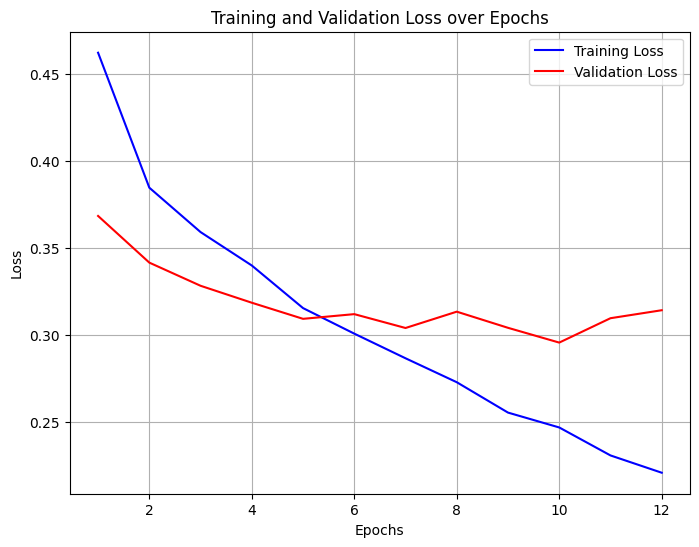

In [9]:
model, train_losses, val_losses = train_model(model,  train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)

plot_losses(train_losses, val_losses)

# Testing on test set with our valius from previous challenge

In [15]:
import importlib
import modules.data_loader

importlib.reload(modules.data_loader)

<module 'modules.data_loader' from 'c:\\Users\\User\\GitHub_Projects\\CAD_DL\\CADx-Project\\2_DL\\code\\modules\\data_loader.py'>

Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


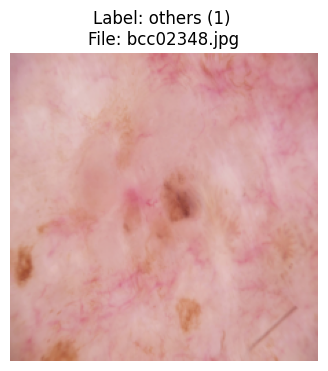

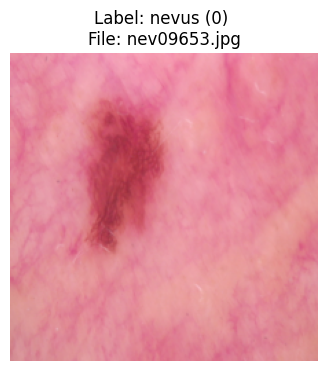

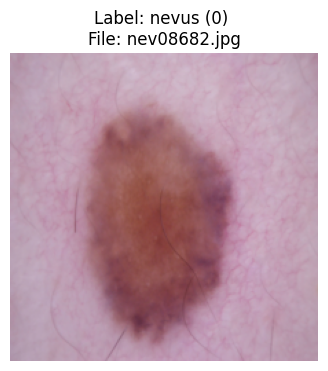

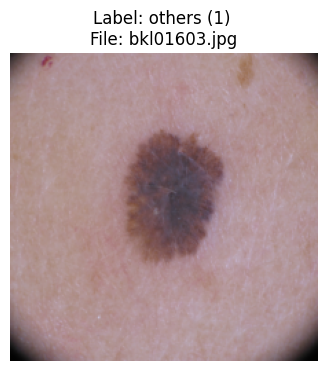

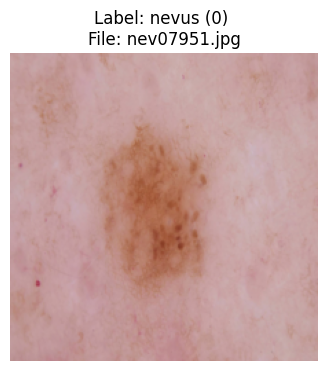

In [16]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(test_loader, mean, std, 5)

# Eval

In [17]:
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in test_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        outputs = model(inputs)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        predictions.extend(preds.cpu().numpy())
        labels.extend(targets.cpu().numpy())



Accuracy: 0.8788
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       966
         1.0       0.88      0.87      0.88       932

    accuracy                           0.88      1898
   macro avg       0.88      0.88      0.88      1898
weighted avg       0.88      0.88      0.88      1898



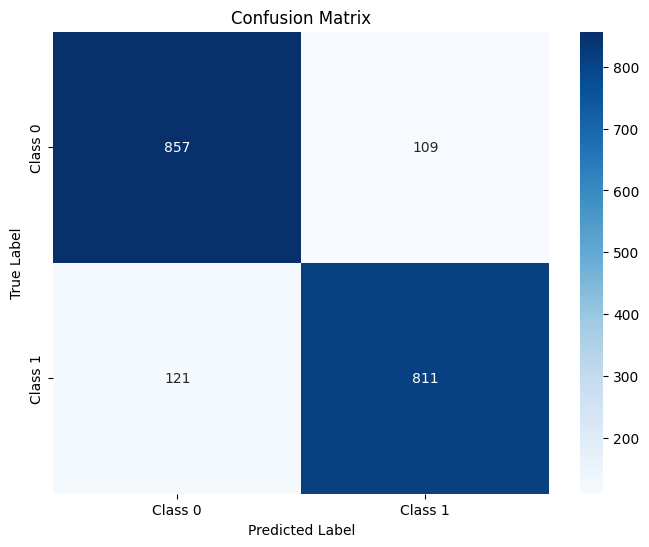

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
cm = confusion_matrix(labels, predictions)
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(labels, predictions))

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot= True, fmt = 'd', cmap = 'Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")
plt.show()

# Load best performance model and make predictions

In [47]:
model_best = SkinLesionClassifier_VIT(num_classes=1)
model_path = "best_model_bin_2.pth"
check_point = torch.load(model_path, map_location= device)
model_best.load_state_dict(check_point["model_state_dict"])

model_best.to(device)
model_best.eval()


C:\Users\User\AppData\Local\Temp\ipykernel_37032\1099051069.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(model_path, map_location= device)


SkinLesionClassifier_VIT(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
        

In [50]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs) #due to BCEWithLogitLoss
        predictions = (probabilities > 0.5).float() #conver to binary preds

        all_preds.append(predictions.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds, dim = 0)
all_labels = torch.cat(all_labels, dim = 0 )    

Accuracy: 0.8788
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       966
           1       0.88      0.87      0.88       932

    accuracy                           0.88      1898
   macro avg       0.88      0.88      0.88      1898
weighted avg       0.88      0.88      0.88      1898



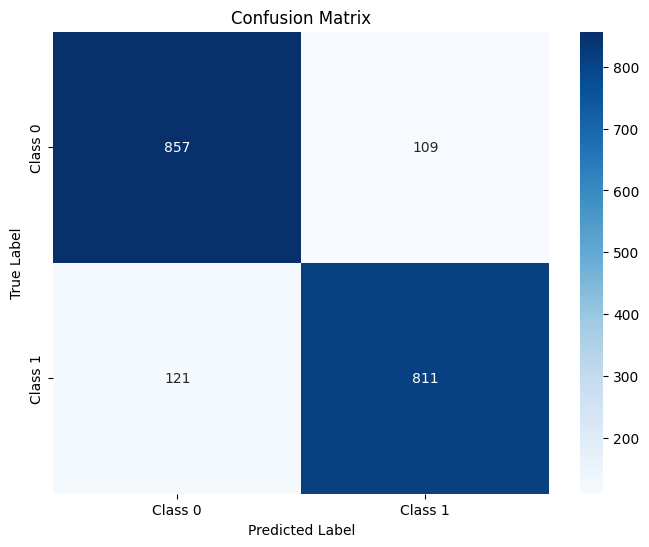

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

predictions = all_preds.numpy()
labels = all_labels.numpy()
cm = confusion_matrix(labels, predictions)
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(labels, predictions))

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot= True, fmt = 'd', cmap = 'Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")
plt.show()

# Predictions over real test set and csv creation

In [25]:
from modules.data_loader_vit import get_data_loader_test

In [35]:
test_real_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\test_without_changes".replace("\\","/")

test_real_loader = get_data_loader_test(test_real_path, batch_size=1)


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


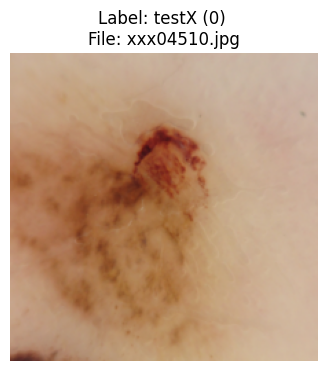

In [46]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(test_real_loader, mean, std, 1)

# Make predictions

In [ ]:
import pandas as pd
#Check which model are you going to really use
model.eval()

predictions = []
filenames = []

with torch.no_grad():
    for inputs, _, paths in test_real_loader:
        file_name = os.path.basename(paths[0])
        print(file_name)
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy() #binary probs

        binary_predictions = (probabilities > 0.5).astype(int)

        if isinstance(binary_predictions, np.int64):
            predictions.append(binary_predictions)
        else:
            predictions.extend(binary_predictions)
        filenames.extend(file_name)

results_df = pd.DataFrame({
    "filename":filenames,
    "prediction":predictions
})

results_df.to_csv("test_predictions_Vtrans.csv", index=False)

xxx04575.jpg


TypeError: 'numpy.int64' object is not iterable